# Average and STD per year

In this notebook, we plot **Figures 3(b) and 3(c)**. To do so, we need parse all the ratings per year and put them in a JSON. Then, we need to compute the average and the std per year with bootstraping and add them in JSON files

*No requirement is needed to run this notebook.*

**Benchmark time**: This notebook has been run on a Dell Latitude (ElementaryOS 0.4.1 Loki, i7-7600U, 16GB RAM).

In [1]:
import os
os.chdir('..')

In [2]:
# Helpers functions
from python.helpers import parse

# Libraries for preparing data
import json
import numpy as np
from datetime import datetime

# Libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib

# Folders
data_folder = '../data/'
fig_folder = '../figures/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# General info for plotting
colors = {'ba': (232/255,164/255,29/255), 
          'rb': (0/255,152/255,205/255)}

labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

# Check that folders exist
if not os.path.exists(data_folder + 'tmp'):
    os.makedirs(data_folder + 'tmp')

if not os.path.exists(data_folder + 'prepared'):
    os.makedirs(data_folder + 'prepared')
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

## Parse the ratings per year

In the first cell, we prepare the ratings per year. In the second cell, we compute the average and the std per year with bootstraping. 

In [3]:
%%time

# Get the ratings for every year for both BA and RB
ratings_year = {'ba': {}, 'rb': {}}

# Go through RB and BA
for key in ratings_year.keys():
    print('Parsing {} reviews.'.format(key.upper()))
    
    # Get the iterator
    gen = parse(data_folder + key + '/ratings.txt.gz'.format(key))
    
    # Go through the iterator
    for item in gen:
        
        # Get the data and then the year
        date = int(item['date'])
        year = datetime.fromtimestamp(date).year
                        
        if year not in ratings_year[key].keys():
            ratings_year[key][year] = []
        
        # Add the rating in the correct year
        ratings_year[key][year].append(float(item['rating']))
        
with open(data_folder + 'tmp/rating_per_year.json', 'w') as outfile:
    json.dump(ratings_year, outfile)

Parsing BA reviews.
Parsing RB reviews.
CPU times: user 10min 41s, sys: 1.52 s, total: 10min 43s
Wall time: 10min 44s


In [4]:
%%time

with open(data_folder + 'tmp/rating_per_year.json', 'r') as infile:
    ratings_year = json.load(infile)

# Span of years
years = list(range(2001, 2018))

# Number of draws for the bootstrap
nbr_draws = 1000

# Prepare the two dicts
avg = {}
std = {}

# Go through RB and BA
for key in ratings_year:
    # Prepare the dict
    avg[key] = {'mean': [], 'low': [], 'high': []}
    std[key] = {'mean': [], 'low': [], 'high': []}
    
    # Go through every year
    for y in years:
        # Get the ratings from this year
        vals = np.array(ratings_year[key][str(y)])
           
        # Two temp array for the average and the std
        tmp_avg = []
        tmp_std = []
        
        # Go through draws of bootstrap
        for i in range(nbr_draws):
            # Get indices with replacements
            indices = np.random.randint(0, len(vals), len(vals))
            
            # The new array of ratings
            vals_tmp = vals[indices]
            
            # Add the avg in tmp_avg
            tmp_avg.append(np.mean(vals_tmp))
            # Add the std in tmp_std
            tmp_std.append(np.std(vals_tmp))
        
        # Compute the values for 95% confidence interval for avg
        avg[key]['mean'].append(np.mean(tmp_avg))
        avg[key]['low'].append(np.percentile(tmp_avg, 2.5))
        avg[key]['high'].append(np.percentile(tmp_avg, 97.5))
        
        # Compute the values for 95% confidence interval for std
        std[key]['mean'].append(np.mean(tmp_std))
        std[key]['low'].append(np.percentile(tmp_std, 2.5))
        std[key]['high'].append(np.percentile(tmp_std, 97.5))
        
# Save the avg per year
with open(data_folder + 'prepared/avg_year.json', 'w') as outfile:
    json.dump(avg, outfile)
    
# Save the std per year
with open(data_folder + 'prepared/std_year.json', 'w') as outfile:
    json.dump(std, outfile)

CPU times: user 5min 29s, sys: 252 ms, total: 5min 30s
Wall time: 5min 32s


## Plot the avg and std per year

The first cell plots the average per year (Figure 3(b)) and the second cell plots the std per year (Figure 3(c)).

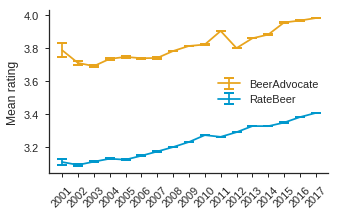

In [5]:
with open(data_folder + 'prepared/avg_year.json', 'r') as infile:
    avg = json.load(infile)
    
years = list(range(2001, 2018))
x = np.array(range(len(years)))

plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for key in avg.keys():
    vals = np.array(avg[key]['mean'])
    high = np.array(avg[key]['high'])
    low = np.array(avg[key]['low'])
    conf_int = np.array([high-vals, vals-low])

    
    plt.errorbar(x, vals , yerr=conf_int, 
                 color=colors[key], fmt='-', 
                 label=labels[key], 
                 capsize=5, capthick=2)
    
plt.xticks(list(range(len(years))), years, rotation=45)
plt.ylabel('Mean rating')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)

plt.savefig(fig_folder + 'avg_rating_per_year.pdf', bbox_inches='tight')

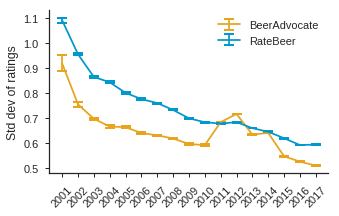

In [6]:
with open(data_folder + 'prepared/std_year.json', 'r') as infile:
    std = json.load(infile)

years = list(range(2001, 2018))
x = np.array(range(len(years)))

plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for key in std.keys():
    vals = np.array(std[key]['mean'])
    high = np.array(std[key]['high'])
    low = np.array(std[key]['low'])
    conf_int = np.array([high-vals, vals-low])

    
    plt.errorbar(x, vals , yerr=conf_int, 
                 color=colors[key], fmt='-', 
                 label=labels[key], 
                 capsize=5, capthick=2)
    
plt.xticks(list(range(len(years))), years, rotation=45)
plt.ylabel('Std dev of ratings')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)

plt.savefig(fig_folder + 'std_rating_per_year.pdf', bbox_inches='tight')